In [2]:
import deepchem as dc
dc.__version__

'2.7.1'

# Creando Datasets desde datos experimentales

En este tutorial, veremos lo que implica la creación de un nuevo conjunto de datos a partir de datos experimentales. Como veremos, la creación del objeto de conjunto de datos es solo una pequeña parte del proceso. La mayoría de los conjuntos de datos reales requieren una limpieza significativa y un control de calidad antes de que sean adecuados para entrenar modelos.


## Working With Data Files

Supongamos que te han proporcionado datos recopilados por un colaborador experimental y deseas utilizar estos datos para construir un modelo de aprendizaje automático.

¿Cómo transformas estos datos en un conjunto de datos capaz de crear un modelo útil?

La construcción de modelos a partir de datos nuevos puede plantear varios desafíos. Tal vez los datos no se registraron de manera conveniente. Además, es posible que los datos contengan ruido. Esto es algo común en, por ejemplo, ensayos biológicos debido al gran número de variables externas y a la dificultad y el costo asociados con la recopilación de múltiples muestras. Esto es un problema porque no deseas que tu modelo se ajuste a este ruido.

Por lo tanto, existen dos desafíos principales:

1. Analizar los datos.
2. Desruidizar los datos.

En este tutorial, vamos a recorrer un ejemplo de cómo crear un conjunto de datos a partir de una hoja de cálculo de Excel con medidas experimentales de medicamentos. Antes de adentrarnos en este ejemplo, hagamos una breve revisión de las capacidades de manejo de archivos de entrada y featurización de DeepChem.

Formatos de entrada
DeepChem admite una amplia gama de formatos de entrada. Por ejemplo, los formatos de entrada aceptados incluyen .csv, .sdf, .fasta, .png, .tif y otros formatos de archivo. La carga de un formato de archivo en particular está gobernada por la clase Loader asociada con ese formato. Por ejemplo, para cargar un archivo .csv, utilizamos la clase CSVLoader. Aquí tienes un ejemplo de un archivo .csv que cumple con los requisitos de CSVLoader:

- Una columna que contiene cadenas SMILES.
- Una columna que contiene una medida experimental.
- (Opcional) Una columna que contiene un identificador único de compuesto.

### Featurización de datos

La mayoría de los algoritmos de aprendizaje automático requieren que los datos de entrada se conviertan en vectores. Sin embargo, los datos de entrada para conjuntos de datos de descubrimiento de medicamentos suelen presentarse en forma de listas de moléculas y resultados experimentales asociados. Para cargar los datos, utilizamos una subclase de dc.data.DataLoader, como dc.data.CSVLoader o dc.data.SDFLoader. Los usuarios pueden crear subclases de dc.data.DataLoader para cargar formatos de archivo arbitrarios. Todos los Loaders deben recibir un objeto dc.feat.Featurizer, que especifica cómo transformar las moléculas en vectores. DeepChem proporciona varias subclases diferentes de dc.feat.Featurizer.

### Parsing data

Para leer los datos, utilizaremos la biblioteca de análisis de datos pandas.

Para convertir los nombres de los medicamentos en cadenas SMILES, utilizaremos pubchempy. Esto no es una dependencia estándar de DeepChem, pero puedes instalar esta biblioteca con `conda install pubchempy`.


In [9]:
import os
import pandas as pd
from pubchempy import get_cids, get_compounds

Veremos nuestros datos usando un GUI (como excel)

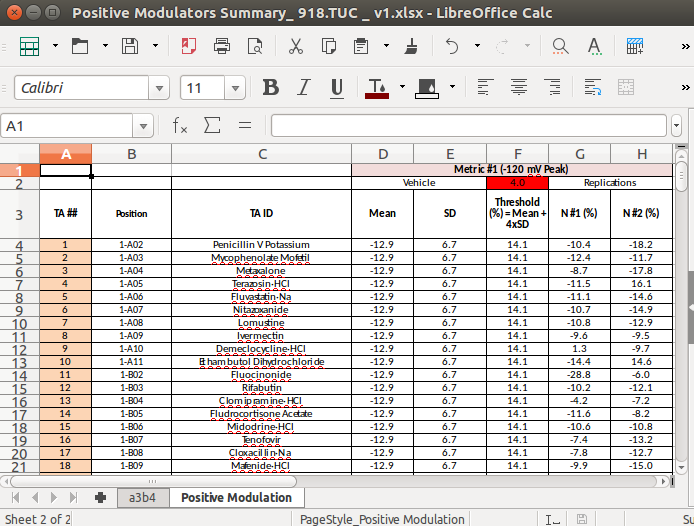

Podemos ver como los datos de interes estan en la segunda hoja que contiene la información en distintas columnas

Además, parece que gran parte de esta hoja de cálculo se formateó para facilitar su lectura por humanos (encabezados de varias columnas, etiquetas de columna con espacios y símbolos, etc.). Esto dificulta la creación de un objeto de dataframe ordenado. Por esta razón, eliminaremos todo lo que sea innecesario o incómodo.

In [11]:
dc.utils.download_url(
    'https://github.com/deepchem/deepchem/raw/master/datasets/Positive%20Modulators%20Summary_%20918.TUC%20_%20v1.xlsx',
    current_dir,
    'Positive Modulators Summary_ 918.TUC _ v1.xlsx'
)

In [12]:
raw_data_file = os.path.join(current_dir, 'Positive Modulators Summary_ 918.TUC _ v1.xlsx')
raw_data_excel = pd.ExcelFile(raw_data_file)

# second sheet only
raw_data = raw_data_excel.parse(raw_data_excel.sheet_names[1])

In [13]:
# preview 5 rows of raw dataframe
raw_data.loc[raw_data.index[:5]]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Metric #1 (-120 mV Peak),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,Vehicle,NaN,4,Replications,NaN
1,TA ##,Position,TA ID,Mean,SD,Threshold (%) = Mean + 4xSD,N #1 (%),N #2 (%)
2,1,1-A02,Penicillin V Potassium,-12.868936,6.747049,14.119261,-10.40397,-18.192942
3,2,1-A03,Mycophenolate Mofetil,-12.868936,6.747049,14.119261,-12.445268,-11.717468
4,3,1-A04,Metaxalone,-12.868936,6.747049,14.119261,-8.655724,-17.775287


Ahora debemos indicar cuales son nuestras columnas y solo nos vamos a quedar con 4

In [15]:
# remove column labels (rows 0 and 1), as we will replace them
# only take data given in columns "TA ID" "N #1 (%)" (3) and "N #2 (%)" (4)
raw_data = raw_data.iloc[2:, [2, 6, 7]]

# reset the index so we keep the label but number from 0 again
raw_data.reset_index(inplace=True)

## rename columns
raw_data.columns = ['label', 'drug', 'n1', 'n2']

In [20]:
# preview cleaner dataframe
raw_data.loc[raw_data.index[:5]]

,label,drug,n1,n2
0,2,Penicillin V Potassium,-10.40397,-18.192942
1,3,Mycophenolate Mofetil,-12.445268,-11.717468
2,4,Metaxalone,-8.655724,-17.775287
3,5,Terazosin·HCl,-11.504804,16.082458
4,6,Fluvastatin·Na,-11.135366,-14.553018


Esto ya se va pareciendo más a lo que solemos trabajar

In [21]:
drugs = raw_data['drug'].values

Para muchas de estas, podemos obtener la cadena SMILES a través del atributo canonical_smiles del objeto get_compounds (usando pubchempy).


In [27]:
get_compounds(drugs[1], 'name') #Función de pubchempy


[Compound(5281078)]

In [28]:
get_compounds(drugs[1], 'name')[0].canonical_smiles

'CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3CCOCC3)O'

Sin embargo, algunos de estos nombres de medicamentos tienen espacios y símbolos variables (·, (±), etc.), y nombres que pueden no ser legibles para pubchempy.

Para esta tarea, realizaremos un poco de manipulación de datos utilizando expresiones regulares. Además, observamos que todas las iones están escritos en una forma abreviada que necesitará expandirse. Por esta razón, utilizamos un diccionario que asigna los nombres abreviados de los iones a versiones reconocibles por pubchempy.

Desafortunadamente, es posible que haya varios casos especiales que requieran más manipulación de datos.


In [35]:
import re

ion_replacements = {
    'HBr': ' hydrobromide',
    '2Br': ' dibromide',
    'Br': ' bromide',
    'HCl': ' hydrochloride',
    '2H2O': ' dihydrate',
    'H20': ' hydrate',
    'Na': ' sodium'
}

ion_keys = ['H20', 'HBr', 'HCl', '2Br', '2H2O', 'Br', 'Na']

def compound_to_smiles(cmpd):
    # remove spaces and irregular characters
    compound = re.sub(r'([^\s\w]|_)+', '', cmpd)
                   
    # replace ion names if needed
    for ion in ion_keys:
        if ion in compound:
            compound = compound.replace(ion, ion_replacements[ion])

    # query for cid first in order to avoid timeouterror
    cid = get_cids(compound, 'name')[0] #Obtenemos una especie de ID
    smiles = get_compounds(cid)[0].canonical_smiles

    return smiles

Ahora convirtamos realmente todos estos compuestos a SMILES. Esta conversión llevará unos minutos, así que podría ser un buen momento para tomar un café o un té y descansar mientras esto se ejecuta. Ten en cuenta que esta conversión a veces fallará, por lo que hemos agregado manejo de errores para atrapar estos casos a continuación.


In [36]:
smiles_map = {}
for i, compound in enumerate(drugs): #Por cada farmaco
    try: #Intenta pasarlo a smiles mediante la función anterior
        smiles_map[compound] = compound_to_smiles(compound)
    except: #Si da error
        print("Errored on %s" % i) #Imprime el componente donde esta el error
        continue #Sigue ejecutando

Errored on 162
Errored on 183
Errored on 248


In [38]:
smiles_data = raw_data
# map drug name to smiles string
smiles_data['drug'] = smiles_data['drug'].apply(lambda x: smiles_map[x] if x in smiles_map else None)

In [39]:
# preview smiles data
smiles_data.loc[smiles_data.index[:5]]

,label,drug,n1,n2
0,2,CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)[...,-10.40397,-18.192942
1,3,CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3C...,-12.445268,-11.717468
2,4,CC1=CC(=CC(=C1)OCC2CNC(=O)O2)C,-8.655724,-17.775287
3,5,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4CC...,-11.504804,16.082458
4,6,CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)[O-])O)O)...,-11.135366,-14.553018


Hemos asignado cada nombre de medicamento a su código SMILES correspondiente.

Ahora, necesitamos examinar los datos y eliminar la mayor cantidad de ruido posible.

## Desruidización de datos
En el aprendizaje automático, sabemos que no existe una solución única para todos. Deberás invertir tiempo en analizar y comprender tus datos para enmarcar tu problema y determinar el marco de trabajo del modelo apropiado. El tratamiento de tus datos dependerá de las conclusiones que obtengas de este proceso.

Preguntas que debes hacerte:

1. ¿Qué estás tratando de lograr?
2. ¿Cuál es tu ensayo?
3. ¿Cuál es la estructura de los datos?
4. ¿Tienen sentido los datos?
5. ¿Qué se ha intentado previamente?

Para este proyecto (respectivamente):

1. Me gustaría construir un modelo capaz de predecir la afinidad de una pequeña molécula de fármaco arbitraria a una proteína de canal iónico específica.
2. Datos que describen la inhibición del canal para un fármaco de entrada.
3. Unas pocas centenas de fármacos, con n=2.
4. Necesitaremos examinar más de cerca el conjunto de datos.
5. No se ha hecho nada en esta proteína en particular.

* Esto implicará la creación de gráficos, por lo que importaremos matplotlib y seaborn. También tendremos que examinar las estructuras moleculares, por lo que importaremos rdkit. También utilizaremos la biblioteca seaborn, que puedes instalar con conda install seaborn.


In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import numpy as np

Nuestro objetivo es construir un modelo con moléculas pequeñas. Por lo tanto, vamos a asegurarnos que nuestras moléculas sean pequeñas. Esto se puede aproximar al tamaño de cada String SMILES

Text(0, 0.5, 'probability')

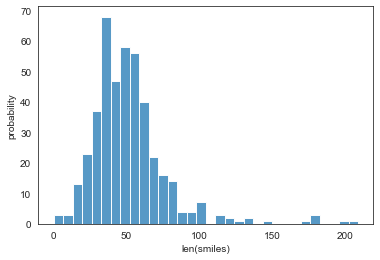

In [41]:
smiles_data['len'] = [len(i) if i is not None else 0 for i in smiles_data['drug']]
smiles_lens = [len(i) if i is not None else 0 for i in smiles_data['drug']]
sns.histplot(smiles_lens)
plt.xlabel('len(smiles)')
plt.ylabel('probability')

Algunos de ellos tienen un len(smiles) > 150. Veamos como su estructura.

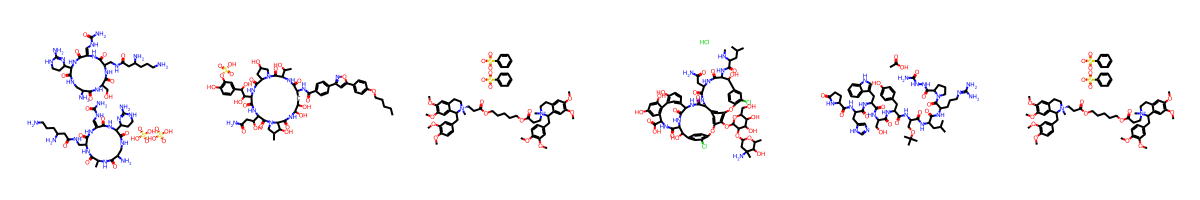

In [42]:
# indices of large looking molecules
suspiciously_large = np.where(np.array(smiles_lens) > 150)[0]

# corresponding smiles string
long_smiles = smiles_data.loc[smiles_data.index[suspiciously_large]]['drug'].values

# look
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in long_smiles], molsPerRow=6)

Como sospechábamos, estas no son pequeñas moléculas, por lo que las eliminaremos del conjunto de datos. El argumento aquí es que estas moléculas podrían registrar inhibidores simplemente porque son grandes. Es más probable que bloqueen estéricamente el canal en lugar de difundir y unirse en el interior (que es lo que nos interesa como funcionalidad del fármaco contra la diana).

La lección aquí es eliminar datos que no se ajusten a tu caso de uso.


In [43]:
# Eliminar large molecules
smiles_data = smiles_data[~smiles_data['drug'].isin(long_smiles)]

Examinemos ahora la estructura numérica del dataset. Veamos primeros los NaNs (valores perdidos)

In [44]:
nan_rows = smiles_data[smiles_data.isnull().T.any().T]
nan_rows[['n1', 'n2']]

,n1,n2
62,NaN,-7.826604
162,-12.845569,-11.462743
175,NaN,-6.612245
183,-12.104264,-7.474597
187,NaN,-8.233257
233,-8.21781,NaN
248,-7.074387,-12.663542
262,NaN,-12.878803
288,NaN,-2.34264
300,NaN,-8.199364


In [45]:
#Eliminamos los datos que tengan NaNs
df = smiles_data.dropna(axis=0, how='any')

Estudiemos ahora la distribución de n1 y n2

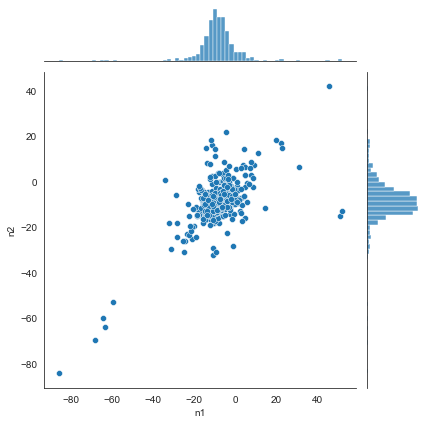

In [46]:
# seaborn jointplot will allow us to compare n1 and n2, and plot each marginal
sns.jointplot(x='n1', y='n2', data=smiles_data) 

Observamos que la mayor parte de los datos se encuentra en una campana de gauss centrada un poco por debajo de cero. También vemos que hay algunos puntos de datos claramente activos ubicados en la parte inferior izquierda y uno en la parte superior derecha. Estos se distinguen de la mayoría de los datos. ¿Cómo manejamos los datos en la mancha?

Dado que n1 y n2 representan la misma medida, idealmente deberían tener el mismo valor. Este gráfico debería estar fuertemente alineado con la diagonal y el coeficiente de correlación de Pearson debería ser 1. Vemos que esto no es el caso. Esto nos da una idea del error de nuestro ensayo.

Echemos un vistazo más de cerca al error, representando la distribución de (n1 - n2).

Lo suyo es que la diferencia entre n1-n2 sea lo mínima posible (idealmente 0).


Text(0, 0.5, 'probability')

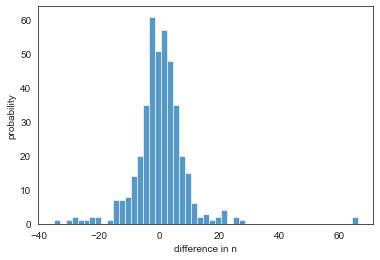

In [47]:
diff_df = df['n1'] - df['n2']

sns.histplot(diff_df)
plt.xlabel('difference in n')
plt.ylabel('probability')

Vemos una distribución bastante gaussiana. Obtenemos ahora el intervalo del 95% de confianza y tomando el doble de la desviación estandar.

In [48]:
from scipy import stats
mean, std = stats.norm.fit(np.asarray(diff_df, dtype=np.float32))
ci_95 = std*2
ci_95

17.817974090576172

Los datos fuera del intervalo de confianza los eliminamos

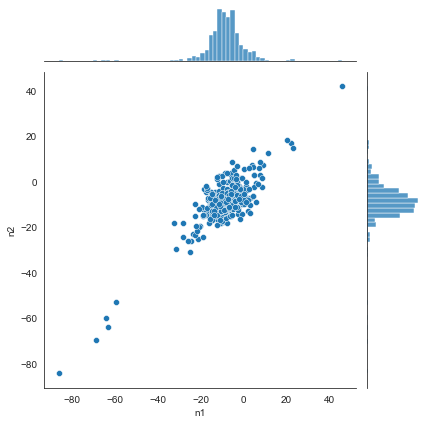

In [49]:
noisy = diff_df[abs(diff_df) > ci_95]
df = df.drop(noisy.index)
sns.jointplot(x='n1', y='n2', data=df) 

Podemos ver como ahora si muestra una linea mucho más definida

In [50]:
avg_df = df[['label', 'drug']].copy()
n_avg = df[['n1', 'n2']].mean(axis=1)
avg_df['n'] = n_avg
avg_df.sort_values('n', inplace=True)

Text(0, 0.5, 'activity')

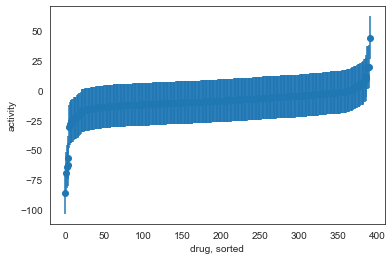

In [52]:
plt.errorbar(np.arange(avg_df.shape[0]), avg_df['n'], yerr=ci_95, fmt='o')
plt.xlabel('drug, sorted')
plt.ylabel('activity')

Ahora, identifiquemos nuestros compuestos activos.

En mi caso, esto requería conocimiento especializado en el dominio. Haber trabajado en esta área y haber consultado con profesores especializados en este canal me lleva a estar interesado en compuestos donde el valor absoluto de la actividad sea mayor que 25. Esto se relaciona con la potencia del medicamento deseada que nos gustaría modelar.

Si no estás seguro de cómo establecer el límite entre activo e inactivo, este valor de corte podría potencialmente tratarse como un hiperparámetro.


<ErrorbarContainer object of 3 artists>

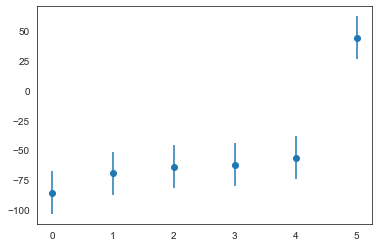

In [55]:
actives = avg_df[abs(avg_df['n'])-ci_95 > 25]['n']

plt.errorbar(np.arange(actives.shape[0]), actives, yerr=ci_95, fmt='o')

In [56]:
# summary
print (raw_data.shape, avg_df.shape, len(actives.index))

(430, 5) (391, 3) 6


En resumen, hemos realizado las siguientes acciones:

1. Eliminado los datos que no abordan la pregunta que esperamos responder (solo moléculas pequeñas).
2. Eliminado los valores NaN.
3. Determinado el ruido de nuestras mediciones.
4. Eliminado puntos de datos excepcionalmente ruidosos.
5. Identificado compuestos activos (utilizando conocimiento de dominio para determinar un umbral).


## Determinación del tipo de modelo y forma final del dataset

Ahora, ¿qué marco de modelo deberíamos utilizar?

Dado que tenemos 392 puntos de datos y 6 compuestos activos, estos datos se utilizarán para construir un clasificador de baja cantidad de datos (one-shot). Si hubiera conjuntos de datos de características similares, potencialmente se podría utilizar el aprendizaje por transferencia, pero este no es el caso en este momento.

Vamos a aplicar lógica a nuestro dataframe para convertirlo en un formato binario adecuado para la clasificación.


In [67]:
# Binarizamos la variable a predecir. Le daremos un 1 si es
# una molécula con actividad alta (25)
avg_df.loc[:, 'active'] = (abs(avg_df['n'])-ci_95 > 25).astype(int)

In [69]:
avg_df.to_csv('modulators.csv', index=False) #Lo guardamos como CSV

Lo convertimos en dataset de deepchem

In [70]:
dataset_file = 'modulators.csv'
task = ['active']
featurizer_func = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=task, feature_field='drug', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file)

Por último, suele ser ventajoso transformar los datos numéricamente de alguna manera. Por ejemplo, a veces es útil normalizar los datos o centrarlos en la media. Esto depende de la tarea en cuestión.

En DeepChem, hay muchos transformadores útiles que se encuentran en la clase base deepchem.transformers.transformers.

Dado que este es un modelo de clasificación y el número de compuestos activos es bajo, aplicaré un transformador de balanceo. Traté este transformador como un hiperparámetro cuando comencé a entrenar modelos y demostró mejorar de manera inequívoca el rendimiento del modelo.


In [71]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
dataset = transformer.transform(dataset)

Ahora guardemos el objeto del conjunto de datos equilibrado en disco y luego volvámoslo a cargar como una verificación de la integridad.


In [72]:
dc.utils.save_to_disk(dataset, 'balanced_dataset.joblib')
balanced_dataset = dc.utils.load_from_disk('balanced_dataset.joblib')